# Koina

In [11]:
%pip install --quiet git+https://github.com/bittremieux/spectrum_utils seaborn koinapy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [52]:
# Basic imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# To plot masss spectra
import spectrum_utils.plot as sup
import spectrum_utils.spectrum as sus

# To download fasta
import requests
import gzip
import subprocess

# To digest fasta
from pyteomics.fasta import FASTA
from pyteomics.parser import cleave

# Predictions with Koina
from koinapy import Koina

# Get predictions

In [53]:
server = "koina.wilhelmlab.org"
ssl = True
prosit2019 = Koina("Prosit_2019_intensity", server_url=server, ssl=ssl)

In [62]:
data = pd.DataFrame(
    {
        "peptide_sequences": np.array(
            ["VLHPLEGAVVIIFK", "VLHPLEGAVVLIFK", "SGVSRKPAPG"]
        ),
        "precursor_charges": np.array([2, 2, 2]),
        "collision_energies": np.array([25, 25, 25]),
        "instrument_types": np.array(["LUMOS", "LUMOS", "LUMOS"]),
    }
)

In [63]:
# Checkout input data
data

,peptide_sequences,precursor_charges,collision_energies,instrument_types
0,VLHPLEGAVVIIFK,2,25,LUMOS
1,VLHPLEGAVVLIFK,2,25,LUMOS
2,SGVSRKPAPG,2,25,LUMOS


In [64]:
# Get predictions
pred_prosit2019 = prosit2019.predict(data)

Getting predictions:   0%|          | 0/1 [00:00<?, ?it/s]

In [65]:
for key, val in pred_prosit2019.items():
    print(key.ljust(12), val.shape, val[0][:4])

intensities  (3, 174) [ 3.8752858e-02  3.1321477e-08 -1.0000000e+00  3.1321477e-08]
mz           (3, 174) [147.11281  74.06004  -1.      100.07569]
annotation   (3, 174) [b'y1+1' b'y1+2' b'y1+3' b'b1+1']


# Visualize spectra using spectrum_utils

<Axes: xlabel='m/z', ylabel='Intensity'>

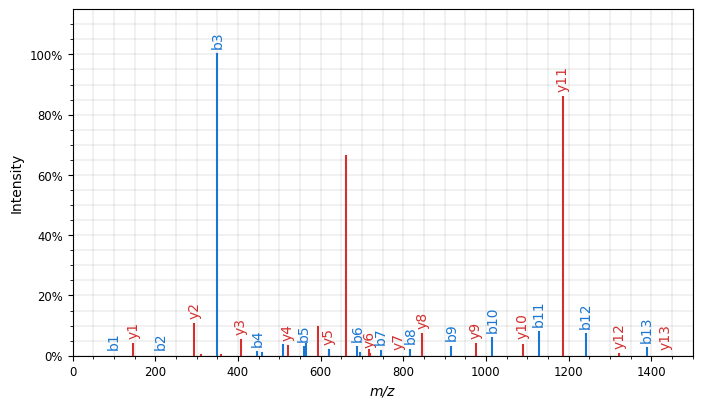

In [73]:
# Initialize a sus.spectrum with our predictions
bot_spectrum = sus.MsmsSpectrum(
    "0", 0, 2, mz=pred_prosit2019["mz"][0], intensity=pred_prosit2019["intensities"][0]
)
# Annotate the spectrum with its ProForma string.
bot_spectrum = bot_spectrum.annotate_proforma(
    "VLHPLEGAVVIIFK", 20, "ppm", ion_types="by", max_ion_charge=2
)

# Plot the spectrum.
fig, ax = plt.subplots(figsize=(8, 4.5))
sup.spectrum(bot_spectrum, ax=ax)

<Axes: xlabel='m/z', ylabel='Intensity'>

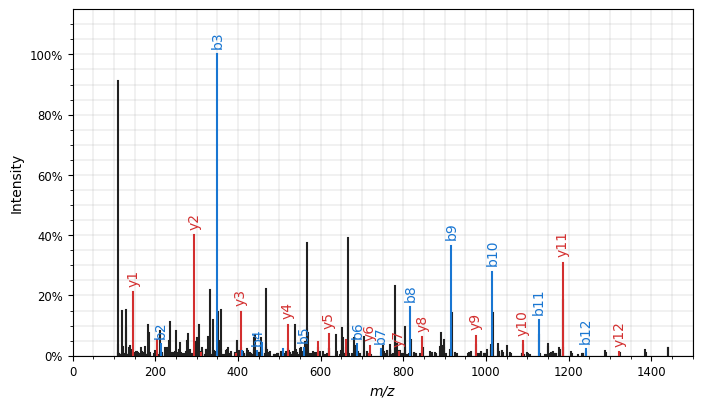

In [74]:
# Initialize a sus.spectrum with an experimental spectrum
top_spectrum = sus.MsmsSpectrum.from_usi(
    "mzspec:PXD000561:Adult_Frontalcortex_bRP_Elite_85_f09:scan:17555:VLHPLEGAVVIIFK/2"
)
# Annotate the spectrum with its ProForma string.
top_spectrum = top_spectrum.annotate_proforma(
    "VLHPLEGAVVIIFK", 20, "ppm", ion_types="by", max_ion_charge=2
)

# Plot the spectrum.
fig, ax = plt.subplots(figsize=(8, 4.5))
sup.spectrum(top_spectrum, ax=ax)

<Axes: xlabel='m/z', ylabel='Intensity'>

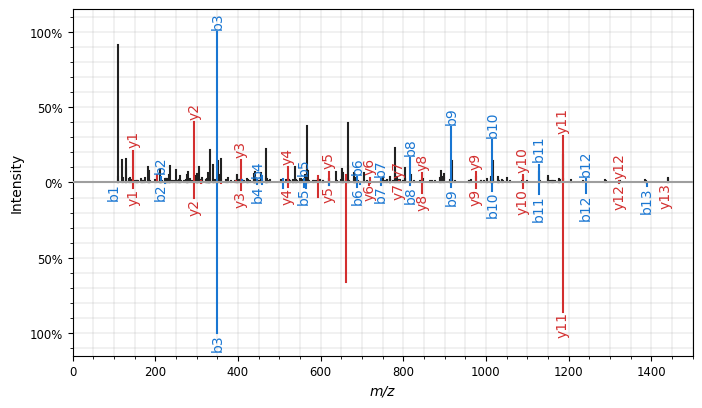

In [76]:
# Create mirror spectra with sup.mirror
fig, ax = plt.subplots(figsize=(8, 4.5))
sup.mirror(top_spectrum, bot_spectrum, ax=ax)

# Compare predictions of different models

In [81]:
prosit2020 = Koina("Prosit_2020_intensity_HCD", server_url=server, ssl=ssl)
ms2pip = Koina("ms2pip_2021_HCD", server_url=server, ssl=ssl)
alphapep = Koina("AlphaPept_ms2_generic", server_url=server, ssl=ssl)

pred_prosit2020 = prosit2020.predict(data)
pred_ms2pip = ms2pip.predict(data)
pred_alphapep = alphapep.predict(data)

Getting predictions:   0%|          | 0/1 [00:00<?, ?it/s]

Getting predictions:   0%|          | 0/1 [00:00<?, ?it/s]

Getting predictions:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: title={'center': 'Prosit_202_intensity_HCD'}, xlabel='m/z', ylabel='Intensity'>

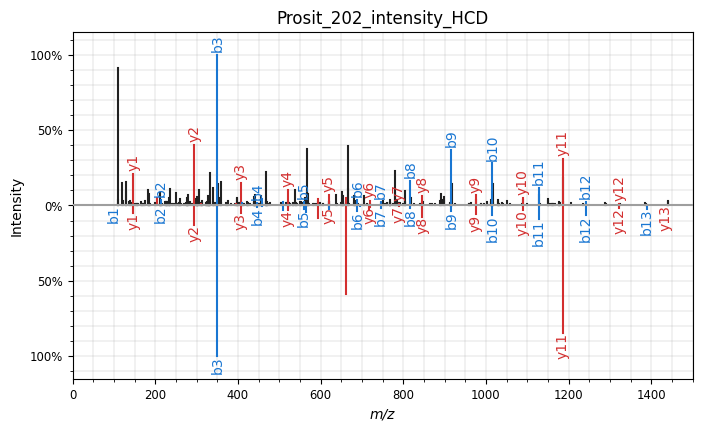

In [82]:
bot_spectrum = sus.MsmsSpectrum(
    "0", 0, 2, mz=pred_prosit2020["mz"][0], intensity=pred_prosit2020["intensities"][0]
)
bot_spectrum = bot_spectrum.annotate_proforma(
    "VLHPLEGAVVIIFK", 20, "ppm", ion_types="by", max_ion_charge=2
)

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.set_title("Prosit_202_intensity_HCD")
sup.mirror(top_spectrum, bot_spectrum, ax=ax)

<Axes: title={'center': 'ms2pip_2021_HCD'}, xlabel='m/z', ylabel='Intensity'>

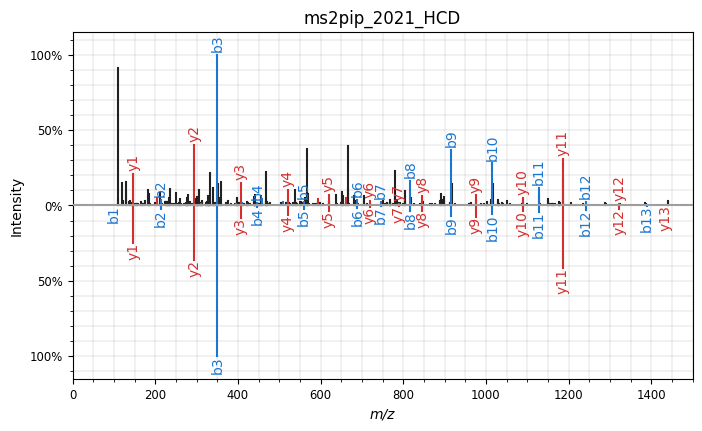

In [83]:
bot_spectrum = sus.MsmsSpectrum(
    "0", 0, 2, mz=pred_ms2pip["mz"][0], intensity=pred_ms2pip["intensities"][0]
)
bot_spectrum = bot_spectrum.annotate_proforma(
    "VLHPLEGAVVIIFK", 20, "ppm", ion_types="by", max_ion_charge=2
)

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.set_title("ms2pip_2021_HCD")
sup.mirror(top_spectrum, bot_spectrum, ax=ax)

<Axes: title={'center': 'AlphaPept_ms2_generic'}, xlabel='m/z', ylabel='Intensity'>

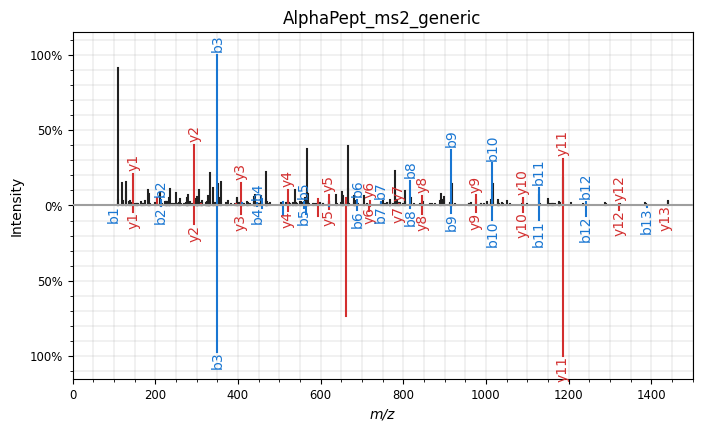

In [85]:
bot_spectrum = sus.MsmsSpectrum(
    "0", 0, 2, mz=pred_alphapep["mz"][0], intensity=pred_alphapep["intensities"][0]
)
bot_spectrum = bot_spectrum.annotate_proforma(
    "VLHPLEGAVVIIFK", 20, "ppm", ion_types="by", max_ion_charge=2
)

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.set_title("AlphaPept_ms2_generic")
sup.mirror(top_spectrum, bot_spectrum, ax=ax)

# Validate HLA peptides

<Axes: xlabel='m/z', ylabel='Intensity'>

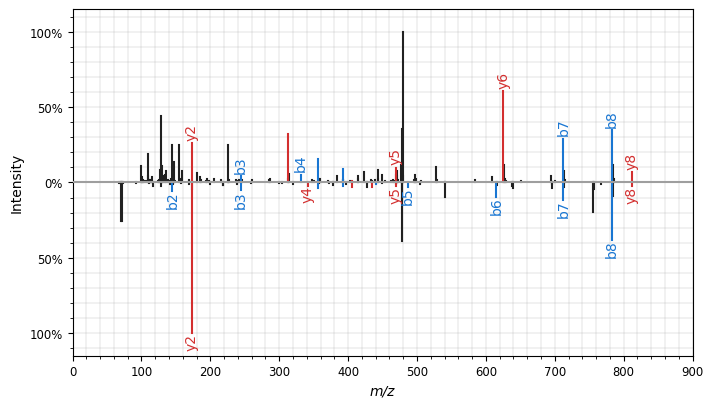

In [86]:
# Identification originally used to reported a novel HLA peptide (Mylonas et al.4 Figure 2A).
top_spectrum = sus.MsmsSpectrum.from_usi(
    "mzspec:PXD000394:20130504_EXQ3_MiBa_SA_Fib-2:scan:4234:SGVSRKPAPG/2",
    precursor_mz=0,
    precursor_charge=2,
)
top_spectrum = top_spectrum.annotate_proforma(
    "SGVSRKPAPG", 20, "ppm", ion_types="aby", max_ion_charge=2
)

# Spectrum of a synthetic peptide for the same peptide SGVSRKPAPG/2 revealing a distinctively different fragmentation pattern from example 4a.
bot_spectrum = sus.MsmsSpectrum.from_usi(
    "mzspec:PXD010793:20170817_QEh1_LC1_HuPa_SplicingPep_10pmol_G2_R01:scan:8296:SGVSRKPAPG/2",
    precursor_mz=0,
    precursor_charge=2,
)
bot_spectrum = bot_spectrum.annotate_proforma(
    "SGVSRKPAPG", 20, "ppm", ion_types="by", max_ion_charge=2
)

fig, ax = plt.subplots(figsize=(8, 4.5))
sup.mirror(top_spectrum, bot_spectrum, ax=ax)

## Use Prosit_2019_intensity



<Axes: title={'center': 'Synthetic vs Prosit_2019_intensity'}, xlabel='m/z', ylabel='Intensity'>

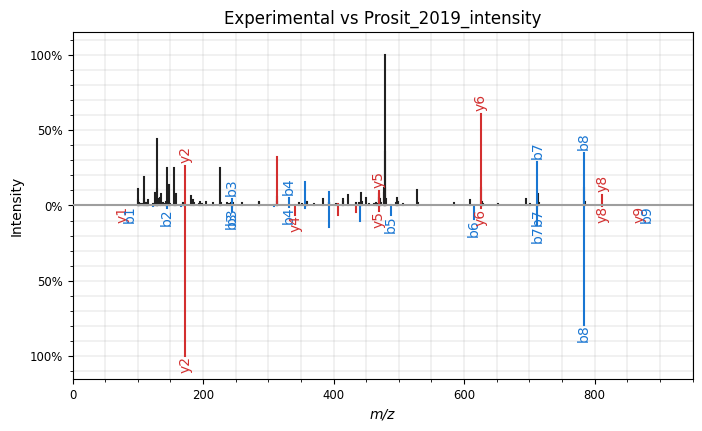

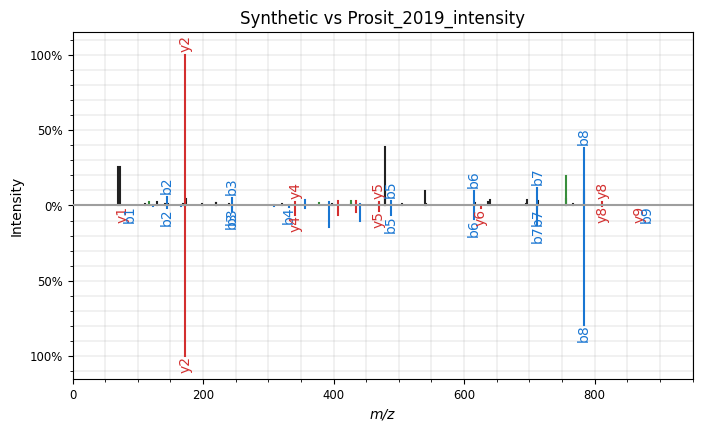

In [87]:
# Identification originally used to reported a novel HLA peptide (Mylonas et al.4 Figure 2A).
top_spectrum = sus.MsmsSpectrum.from_usi(
    "mzspec:PXD000394:20130504_EXQ3_MiBa_SA_Fib-2:scan:4234:SGVSRKPAPG/2",
    precursor_mz=0,
    precursor_charge=2,
)
top_spectrum = top_spectrum.annotate_proforma(
    "SGVSRKPAPG", 20, "ppm", ion_types="aby", max_ion_charge=2
)

bot_spectrum = sus.MsmsSpectrum(
    "0", 0, 2, mz=pred_prosit2019["mz"][2], intensity=pred_prosit2019["intensities"][2]
)
bot_spectrum = bot_spectrum.annotate_proforma(
    "SGVSRKPAPG", 20, "ppm", ion_types="by", max_ion_charge=2
)

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.set_title("Experimental vs Prosit_2019_intensity")
sup.mirror(top_spectrum, bot_spectrum, ax=ax)

# Spectrum of a synthetic peptide for the same peptide SGVSRKPAPG/2 revealing a distinctively different fragmentation pattern from example 4a.
top_spectrum = sus.MsmsSpectrum.from_usi(
    "mzspec:PXD010793:20170817_QEh1_LC1_HuPa_SplicingPep_10pmol_G2_R01:scan:8296:SGVSRKPAPG/2",
    precursor_mz=0,
    precursor_charge=2,
)
top_spectrum = top_spectrum.annotate_proforma(
    "SGVSRKPAPG", 20, "ppm", ion_types="aby", max_ion_charge=2
)

bot_spectrum = sus.MsmsSpectrum(
    "0", 0, 2, mz=pred_prosit2019["mz"][2], intensity=pred_prosit2019["intensities"][2]
)
bot_spectrum = bot_spectrum.annotate_proforma(
    "SGVSRKPAPG", 20, "ppm", ion_types="by", max_ion_charge=2
)

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.set_title("Synthetic vs Prosit_2019_intensity")
sup.mirror(top_spectrum, bot_spectrum, ax=ax)

## Use ms2pip_2021

<Axes: title={'center': 'Synthetic vs ms2pip'}, xlabel='m/z', ylabel='Intensity'>

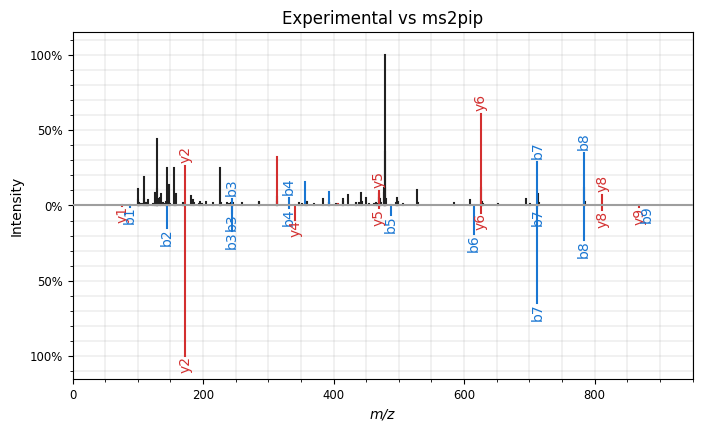

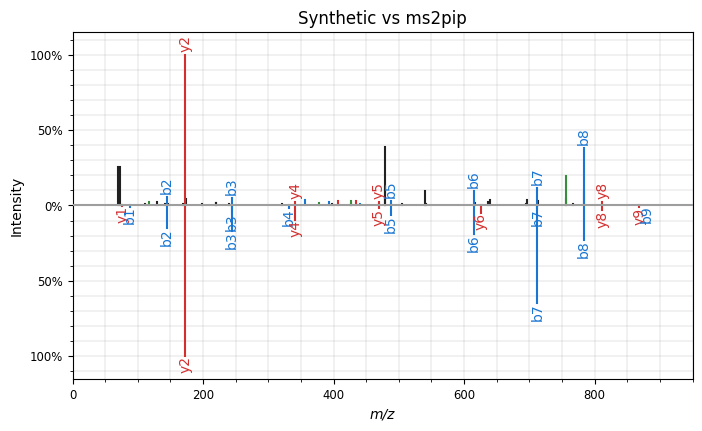

In [29]:
# Identification originally used to reported a novel HLA peptide (Mylonas et al.4 Figure 2A).
top_spectrum = sus.MsmsSpectrum.from_usi(
    "mzspec:PXD000394:20130504_EXQ3_MiBa_SA_Fib-2:scan:4234:SGVSRKPAPG/2",
    precursor_mz=0,
    precursor_charge=2,
)
top_spectrum = top_spectrum.annotate_proforma(
    "SGVSRKPAPG", 20, "ppm", ion_types="aby", max_ion_charge=2
)

bot_spectrum = sus.MsmsSpectrum(
    "0", 0, 2, mz=pred_ms2pip["mz"][2], intensity=pred_ms2pip["intensities"][2]
)
bot_spectrum = bot_spectrum.annotate_proforma(
    "SGVSRKPAPG", 20, "ppm", ion_types="by", max_ion_charge=2
)

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.set_title("Experimental vs ms2pip")
sup.mirror(top_spectrum, bot_spectrum, ax=ax)

# Spectrum of a synthetic peptide for the same peptide SGVSRKPAPG/2 revealing a distinctively different fragmentation pattern from example 4a.
top_spectrum = sus.MsmsSpectrum.from_usi(
    "mzspec:PXD010793:20170817_QEh1_LC1_HuPa_SplicingPep_10pmol_G2_R01:scan:8296:SGVSRKPAPG/2",
    precursor_mz=0,
    precursor_charge=2,
)
top_spectrum = top_spectrum.annotate_proforma(
    "SGVSRKPAPG", 20, "ppm", ion_types="aby", max_ion_charge=2
)

bot_spectrum = sus.MsmsSpectrum(
    "0", 0, 2, mz=pred_ms2pip["mz"][2], intensity=pred_ms2pip["intensities"][2]
)
bot_spectrum = bot_spectrum.annotate_proforma(
    "SGVSRKPAPG", 20, "ppm", ion_types="by", max_ion_charge=2
)

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.set_title("Synthetic vs ms2pip")
sup.mirror(top_spectrum, bot_spectrum, ax=ax)

## Use AlpaPept




<Axes: title={'center': 'Synthetic vs AlphaPept'}, xlabel='m/z', ylabel='Intensity'>

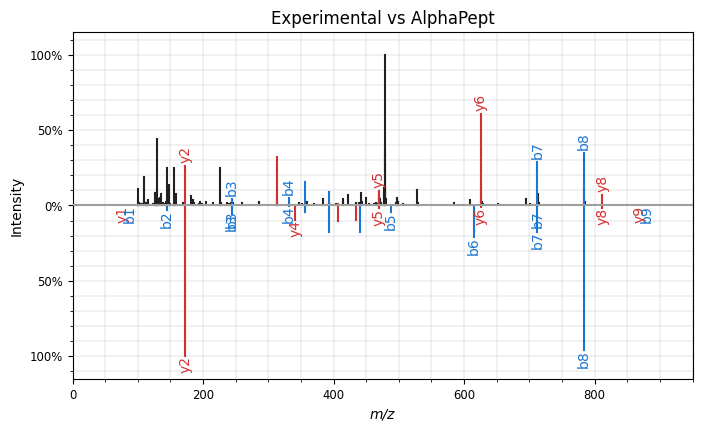

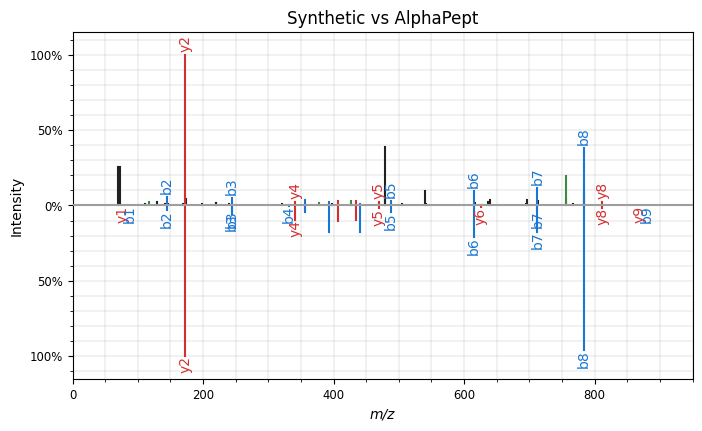

In [30]:
# Identification originally used to reported a novel HLA peptide (Mylonas et al.4 Figure 2A).
top_spectrum = sus.MsmsSpectrum.from_usi(
    "mzspec:PXD000394:20130504_EXQ3_MiBa_SA_Fib-2:scan:4234:SGVSRKPAPG/2",
    precursor_mz=0,
    precursor_charge=2,
)
top_spectrum = top_spectrum.annotate_proforma(
    "SGVSRKPAPG", 20, "ppm", ion_types="aby", max_ion_charge=2
)

bot_spectrum = sus.MsmsSpectrum(
    "0", 0, 2, mz=pred_alphapep["mz"][2], intensity=pred_alphapep["intensities"][2]
)
bot_spectrum = bot_spectrum.annotate_proforma(
    "SGVSRKPAPG", 20, "ppm", ion_types="by", max_ion_charge=2
)

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.set_title("Experimental vs AlphaPept")
sup.mirror(top_spectrum, bot_spectrum, ax=ax)

# Spectrum of a synthetic peptide for the same peptide SGVSRKPAPG/2 revealing a distinctively different fragmentation pattern from example 4a.
top_spectrum = sus.MsmsSpectrum.from_usi(
    "mzspec:PXD010793:20170817_QEh1_LC1_HuPa_SplicingPep_10pmol_G2_R01:scan:8296:SGVSRKPAPG/2",
    precursor_mz=0,
    precursor_charge=2,
)
top_spectrum = top_spectrum.annotate_proforma(
    "SGVSRKPAPG", 20, "ppm", ion_types="aby", max_ion_charge=2
)

bot_spectrum = sus.MsmsSpectrum(
    "0", 0, 2, mz=pred_alphapep["mz"][2], intensity=pred_alphapep["intensities"][2]
)
bot_spectrum = bot_spectrum.annotate_proforma(
    "SGVSRKPAPG", 20, "ppm", ion_types="by", max_ion_charge=2
)

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.set_title("Synthetic vs AlphaPept")
sup.mirror(top_spectrum, bot_spectrum, ax=ax)

# Retention time comparison


In [111]:
url = "https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000005640/UP000005640_9606.fasta.gz"
myfile = requests.get(url)

with open("UP000005640_9606.fasta.gz", "wb") as f_in:
    f_in.write(myfile.content)

_ = subprocess.run(["gunzip", "UP000005640_9606.fasta.gz"])

In [112]:
# Create peptides dataframe

# Digest fasta
peptides = set()
for prot in FASTA("UP000005640_9606.fasta"):
    peptides.update(cleave(prot.sequence, "trypsin", min_length=7, max_length=30))

#
data = pd.DataFrame({"peptide_sequences": np.array(list(peptides))})


data = data[~data["peptide_sequences"].str.contains("X|U")]
# data = data.loc[data["peptide_sequences"].str.len().sort_values().index]
data["peptide_sequences"] = data["peptide_sequences"].str.replace("C", "C[UNIMOD:4]")

In [113]:
data

,peptide_sequences
0,LVGLTGTR
1,ALQQAAEEGR
2,EEC[UNIMOD:4]VSGC[UNIMOD:4]EC[UNIMOD:4]PR
3,GIWSIHVYC[UNIMOD:4]VDNILVK
4,SLSLSLLLHC[UNIMOD:4]IMFNMR
...,...
486514,NYEQWQSQR
486515,VMENSSGTPDILTR
486516,STVESFYSR
486517,TPMSAEMR


In [114]:
prosit2019_irt = Koina("Prosit_2019_irt", server_url=server, ssl=ssl)
deeplc = Koina("Deeplc_hela_hf", server_url=server, ssl=ssl)

In [115]:
data["prosit_irt"] = prosit2019_irt.predict(data)["irt"]
data["deeplc_irt"] = deeplc.predict(data)["irt"]

Getting predictions:   0%|          | 0/487 [00:00<?, ?it/s]

Getting predictions:   0%|          | 0/487 [00:00<?, ?it/s]

<Axes: xlabel='prosit_irt', ylabel='Count'>

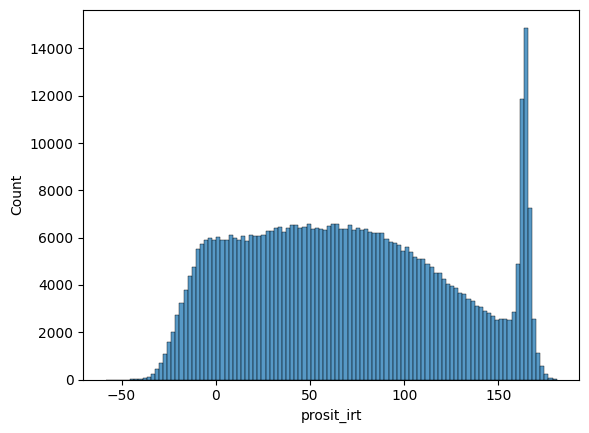

In [116]:
sns.histplot(data, x="prosit_irt")

<Axes: xlabel='deeplc_irt', ylabel='Count'>

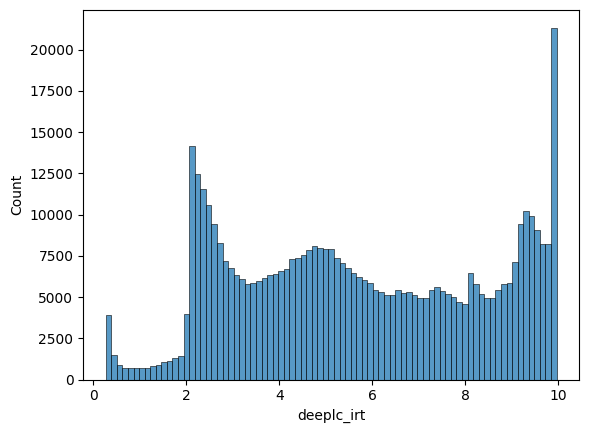

In [117]:
sns.histplot(data, x="deeplc_irt")

<Axes: xlabel='prosit_irt', ylabel='deeplc_irt'>

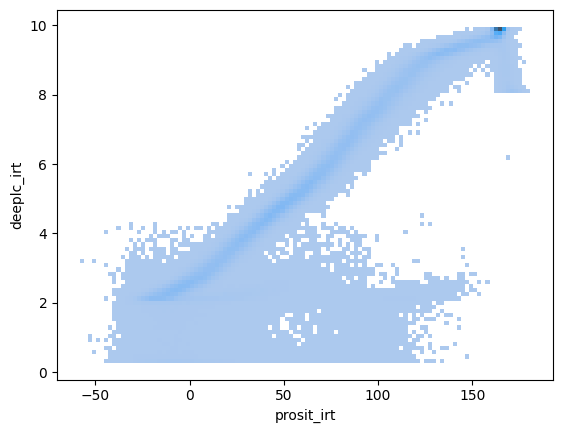

In [118]:
sns.histplot(data, x="prosit_irt", y="deeplc_irt")

In [119]:
data[["prosit_irt", "deeplc_irt"]].corr(method="pearson")

,prosit_irt,deeplc_irt
prosit_irt,1.000000,0.956751
deeplc_irt,0.956751,1.000000
